# Comparison of Full vs Profile Likelihood Methods



### How to run the code

#### On local machine

Run `/benchmark/scripts/benchmark_speed.py`.

The output is stored in `/benchnmark/pickle_results/benchmark_results.pickle`. 


#### Run on cluster

To run this script on a cluster with Torque:

    cd jobfiles
    qsub jobfile_benchmark_speed.pbs

In [1]:
import numpy
import pickle
import pprint
pp = pprint.PrettyPrinter(indent=4)

from os.path import join
import matplotlib
import matplotlib.ticker
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.ticker import MaxNLocator
import seaborn as sns
matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['text.latex.preamble'] = r'\usepackage{amsmath}'
#matplotlib.font_manager._rebuild() 
sns.set(font_scale=1.2)
sns.set_style("white")
sns.set_style("ticks")
plt.rc('font', family='serif')
plt.rcParams['svg.fonttype'] = 'none'

In [2]:
benchmark_dir = '..'
results_filename = join(benchmark_dir, 'pickle_results', 'benchmark_speed.pickle')


with open(results_filename, 'rb') as file:
    benchmark_result = pickle.load(file)
    
print('Config:')
pp.pprint(benchmark_result['config'])
print('')
print('Devices:')
pp.pprint(benchmark_result['devices'])
print('')
results = benchmark_result['results']
num_data = len(results)
print('num data: %d' % num_data)

# Extract variables
data_sizes = benchmark_result['config']['data_sizes']

proc_time = {}
proc_time['full'] = numpy.zeros((num_data), dtype=float)
proc_time['prof'] = numpy.zeros((num_data), dtype=float)

wall_time = {}
wall_time['full'] = numpy.zeros((num_data), dtype=float)
wall_time['prof'] = numpy.zeros((num_data), dtype=float)

sigma = {}
sigma['full'] = numpy.zeros((num_data), dtype=float)
sigma['prof'] = numpy.zeros((num_data), dtype=float)

sigma0 = {}
sigma0['full'] = numpy.zeros((num_data), dtype=float)
sigma0['prof'] = numpy.zeros((num_data), dtype=float)

num_opt_iter = {}
num_opt_iter['full'] = numpy.zeros((num_data), dtype=float)
num_opt_iter['prof'] = numpy.zeros((num_data), dtype=float)

num_fun_eval = {}
num_fun_eval['full'] = numpy.zeros((num_data), dtype=float)
num_fun_eval['prof'] = numpy.zeros((num_data), dtype=float)

num_jac_eval = {}
num_jac_eval['full'] = numpy.zeros((num_data), dtype=float)
num_jac_eval['prof'] = numpy.zeros((num_data), dtype=float)

num_hes_eval = {}
num_hes_eval['full'] = numpy.zeros((num_data), dtype=float)
num_hes_eval['prof'] = numpy.zeros((num_data), dtype=float)

max_fun = {}
max_fun['full'] = numpy.zeros((num_data), dtype=float)
max_fun['prof'] = numpy.zeros((num_data), dtype=float)

success = {}
success['full'] = numpy.zeros((num_data), dtype=float)
success['prof'] = numpy.zeros((num_data), dtype=float)

for i in range(num_data):
    proc_time['full'][i] = results[i]['full_likelihood']['time']['opt_proc_time']
    proc_time['prof'][i] = results[i]['prof_likelihood']['time']['opt_proc_time']
    wall_time['full'][i] = results[i]['full_likelihood']['time']['opt_wall_time']
    wall_time['prof'][i] = results[i]['prof_likelihood']['time']['opt_wall_time']
    
    sigma['full'][i] = results[i]['full_likelihood']['hyperparam']['sigma']
    sigma['prof'][i] = results[i]['prof_likelihood']['hyperparam']['sigma']
    sigma0['full'][i] = results[i]['full_likelihood']['hyperparam']['sigma0']
    sigma0['prof'][i] = results[i]['prof_likelihood']['hyperparam']['sigma0']
    
    num_opt_iter['full'][i] = results[i]['full_likelihood']['optimization']['num_opt_iter']
    num_opt_iter['prof'][i] = results[i]['prof_likelihood']['optimization']['num_opt_iter']
    num_fun_eval['full'][i] = results[i]['full_likelihood']['optimization']['num_fun_eval']
    num_fun_eval['prof'][i] = results[i]['prof_likelihood']['optimization']['num_fun_eval']
    num_jac_eval['full'][i] = results[i]['full_likelihood']['optimization']['num_jac_eval']
    num_jac_eval['prof'][i] = results[i]['prof_likelihood']['optimization']['num_jac_eval']
    num_hes_eval['full'][i] = results[i]['full_likelihood']['optimization']['num_hes_eval']
    num_hes_eval['prof'][i] = results[i]['prof_likelihood']['optimization']['num_hes_eval']
    max_fun['full'][i] = results[i]['full_likelihood']['optimization']['max_fun']
    max_fun['prof'][i] = results[i]['prof_likelihood']['optimization']['max_fun']
    #success['full'][i] = results[i]['full_likelihood']['optimization']['success']
    #success['prof'][i] = results[i]['prof_likelihood']['optimization']['success']

Config:
{   'B': None,
    'b': None,
    'data_sizes': array([ 256,  512, 1024, 2048]),
    'dimension': 1,
    'grid': True,
    'hyperbolic_coeff': None,
    'hyperparam_guess': None,
    'imate_method': 'eigenvalue',
    'kernel': 'Exponential',
    'kernel_threshold': 0.03,
    'noise_magnitude': 0.05,
    'optimization_method': 'Nelder-Mead',
    'polynomial_degree': 2,
    'profile_hyperparam': ['none', 'var'],
    'scale': 0.07,
    'scale_prior': 'Uniform',
    'sparse': False,
    'trigonometric_coeff': None,
    'verbose': False}

Devices:
{   'cpu_name': 'none',
    'gpu_name': 'none',
    'num_all_cpu_threads': 'none',
    'num_all_gpu_devices': 'none:'}

num data: 4


In [3]:
def find_slope(x, y):
    """
    finds a in y = x**a
    """
    
    log2_x = numpy.log2(x)
    log2_y = numpy.log2(y)
    
    return numpy.polyfit(log2_x, log2_y, 1)[0]

In [4]:
# Plot Variables
plot_wall_time = False
full_color = '#0093FF'
prof_color = '#77B900'

# ========
# plot var
# ========

def plot_var(ax_, var, ylabel, title, ylog=False):

    ax_.plot(data_sizes, var['full'], '-o', color=full_color, label='full')
    ax_.plot(data_sizes, var['prof'], '-o', color=prof_color, label='profiled')

    handles,labels = ax_.get_legend_handles_labels()
    ax_.legend(handles, labels, fontsize='x-small')

    ax_.set_xscale('log', base=2)
    if ylog:
        ax_.set_yscale('log', base=10)

    ax_.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax_.get_xaxis().get_major_formatter().labelOnlyBase = False
    ax_.set_xticks(data_sizes)

    ax_.set_ylabel(ylabel)
    ax_.set_title(title)

    ax_.set_xlabel(r'$n$')
    ax_.grid(axis='y', which='major')
    
# =========
# save plot
# =========

def save_plot(plt, name):
    
    save_dir = 'svg_plots'
    filename_svg = name + '.svg'
    plt.savefig(join(benchmark_dir, save_dir, filename_svg), transparent=True, bbox_inches='tight')
    print('Plot saved to "%s".' % (filename_svg))

Plot saved to "benchmark_speed_1.svg".


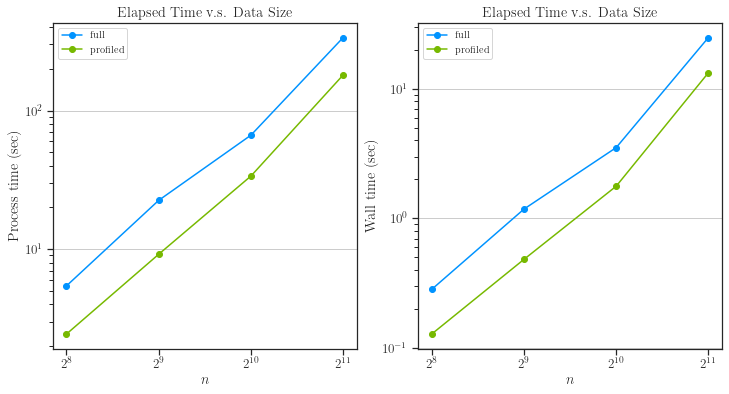

In [5]:
fig, ax = plt.subplots(figsize=(12, 6), nrows=1, ncols=2)

# Plot time
plot_var(ax[0], proc_time, 'Process time (sec)', 'Elapsed Time v.s. Data Size', ylog=True)
plot_var(ax[1], wall_time, 'Wall time (sec)', 'Elapsed Time v.s. Data Size', ylog=True)

# Save plot
save_plot(plt, 'benchmark_speed_1')

Plot saved to "benchmark_speed_2.svg".


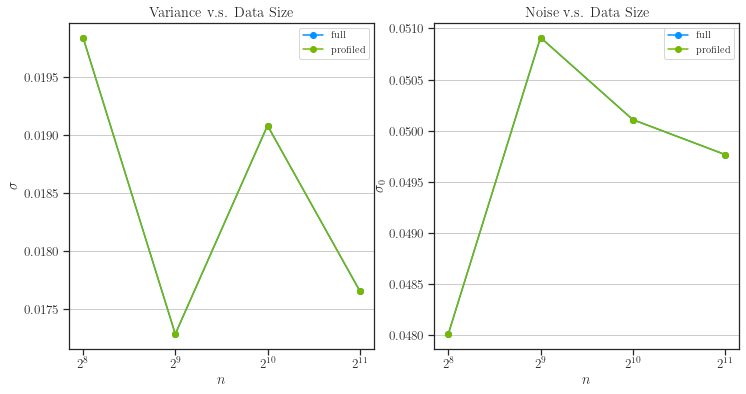

In [6]:
fig, ax = plt.subplots(figsize=(12, 6), nrows=1, ncols=2)

# Plot sigmas
plot_var(ax[0], sigma, r'$\sigma$', 'Variance v.s. Data Size')
plot_var(ax[1], sigma0, r'$\sigma_0$', 'Noise v.s. Data Size')

# Save plot
save_plot(plt, 'benchmark_speed_2')

Plot saved to "benchmark_speed_3.svg".


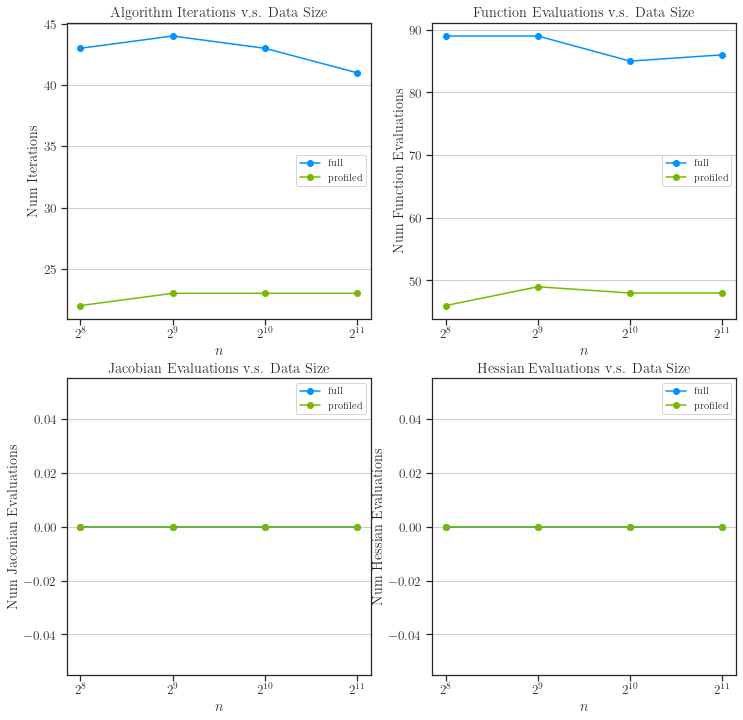

In [7]:
fig, ax = plt.subplots(figsize=(12, 12), nrows=2, ncols=2)

# Plot iterations
plot_var(ax[0, 0], num_opt_iter, 'Num Iterations', 'Algorithm Iterations v.s. Data Size')
plot_var(ax[0, 1], num_fun_eval, 'Num Function Evaluations', 'Function Evaluations v.s. Data Size')
plot_var(ax[1, 0], num_jac_eval, 'Num Jaconian Evaluations', 'Jacobian Evaluations v.s. Data Size')
plot_var(ax[1, 1], num_hes_eval, 'Num Hessian Evaluations', 'Hessian Evaluations v.s. Data Size')

# Save plot
save_plot(plt, 'benchmark_speed_3')

Plot saved to "benchmark_speed_4.svg".


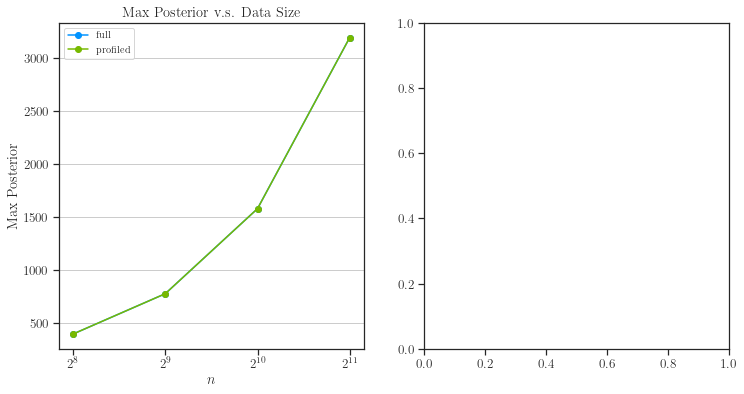

In [8]:
fig, ax = plt.subplots(figsize=(12, 6), nrows=1, ncols=2)

# Plot iterations
plot_var(ax[0], max_fun, 'Max Posterior', 'Max Posterior v.s. Data Size')
#plot_var(ax[1], success, 'Success', 'Convergence Success v.s. Data Size')

# Save plot
save_plot(plt, 'benchmark_speed_4')